In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2 as cv
import math
from PIL import Image, ImageDraw, ImageFont, ImageColor

## Import image

In [2]:
img_path = "/home/thierry/code/zuzannaszu/chess_hackers/Raw_Data/Final_boards/"
img_set = []
img_num = []
start = 1
for i in range(start,start + 10):
    img = cv.imread(img_path + f"Board{i}.jpg", 1)
    img = cv.resize(img,(1280, 1280), interpolation = cv.INTER_AREA)
    img_set.append(img)
    img_num.append(i)
img_set = np.array(img_set)
img_set.shape

(10, 1280, 1280, 3)

In [3]:
def display_multiple_img(array):
    fig, axs = plt.subplots(5,2,figsize=(10,20))
    for i, img in enumerate (array, 1):
        plt.subplot(5,2,i)
        plt.imshow(img)
        plt.title(f"board{start - 1 + i}")
        
def display_compare_img(array1, array2):
    fig, axs = plt.subplots(5,4,figsize=(20,20))
    for i, img in enumerate (zip(array1, array2), 1):
        plt.subplot(5,4, 2 * i - 1)
        plt.imshow(img[0])
        plt.title(f"board{start - 1 + i}")
        plt.subplot(5,4, 2 * i)
        plt.imshow(img[1])
        plt.title(f"board{start - 1 + i}")

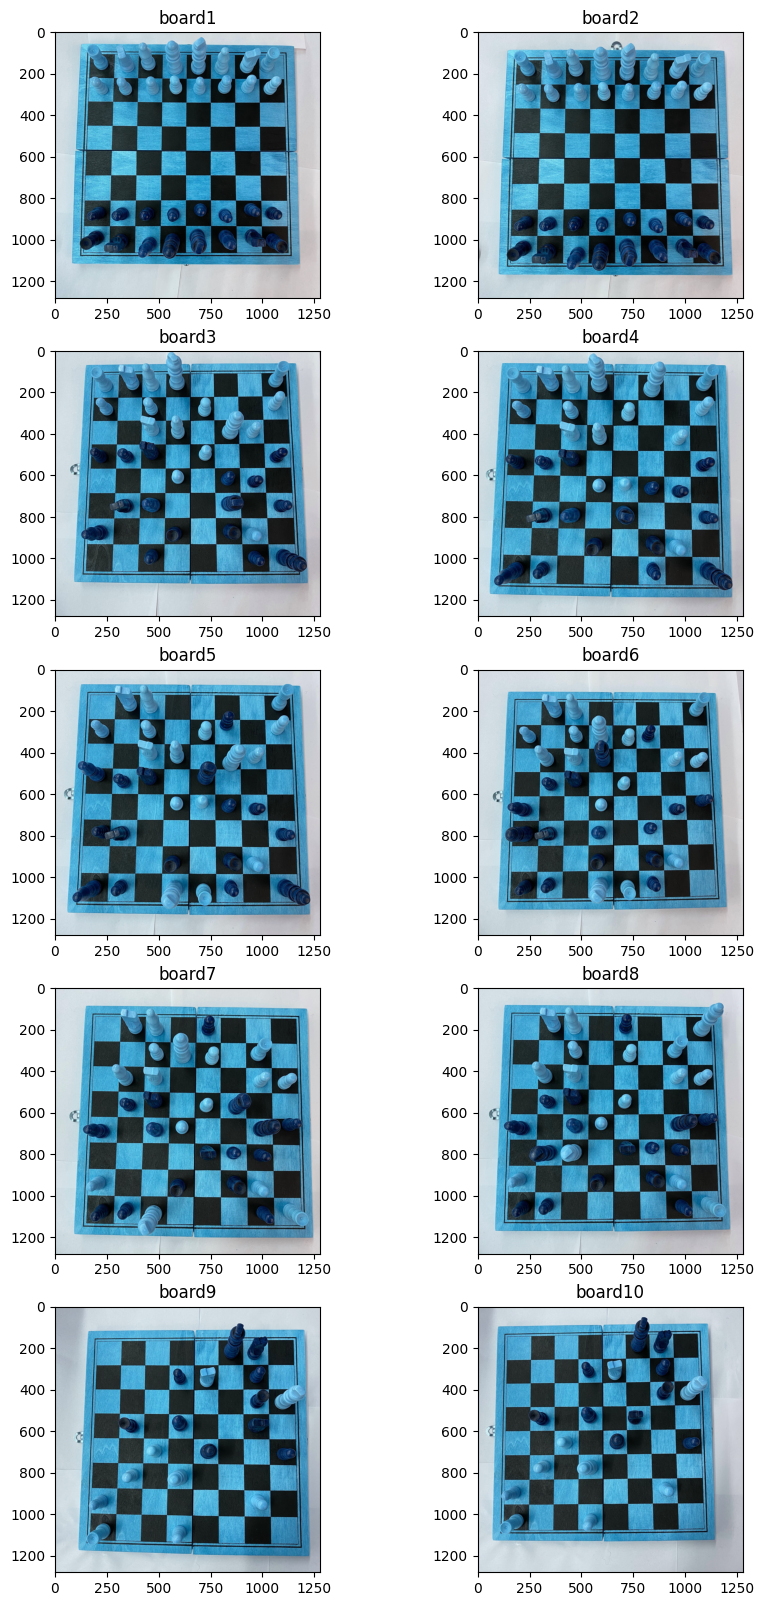

In [4]:
display_multiple_img(img_set)

## Image processing

### Background removal

In [5]:
def bgremove1(myimage):
 
    # Blur to image to reduce noise
    #myimage = cv.cvtColor(myimage, cv.COLOR_GRAY2RGB)
    myimage = cv.GaussianBlur(myimage,(7,7), 0)
 
    # We bin the pixels. Result will be a value 1..5
    bins=np.array([0,51,102,153,204,255])
    myimage[:,:,:] = np.digitize(myimage[:,:,:],bins,right=True)*51
 
    # Create single channel greyscale for thresholding
    myimage_grey = cv.cvtColor(myimage, cv.COLOR_BGR2GRAY)
 
    # Perform Otsu thresholding and extract the background.
    # We use Binary Threshold as we want to create an all white background
    ret,background = cv.threshold(myimage_grey,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
 
    # Convert black and white back into 3 channel greyscale
    background = cv.cvtColor(background, cv.COLOR_GRAY2BGR)
 
    # Perform Otsu thresholding and extract the foreground.
    # We use TOZERO_INV as we want to keep some details of the foregorund
    ret,foreground = cv.threshold(myimage_grey,0,255,cv.THRESH_TOZERO_INV+cv.THRESH_OTSU)  #Currently foreground is only a mask
    foreground = cv.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
 
    return finalimage

def background_op(img, alpha = 1, beta = 0):
    alpha = alpha # Simple contrast control
    beta = beta    # Simple brightness control
    
    image = cv.GaussianBlur(img,(7,7), 0)
    new_image = np.clip(alpha*image + beta, 0, 255).astype("uint8")
    image_1 = bgremove1(new_image)
    
    return image_1

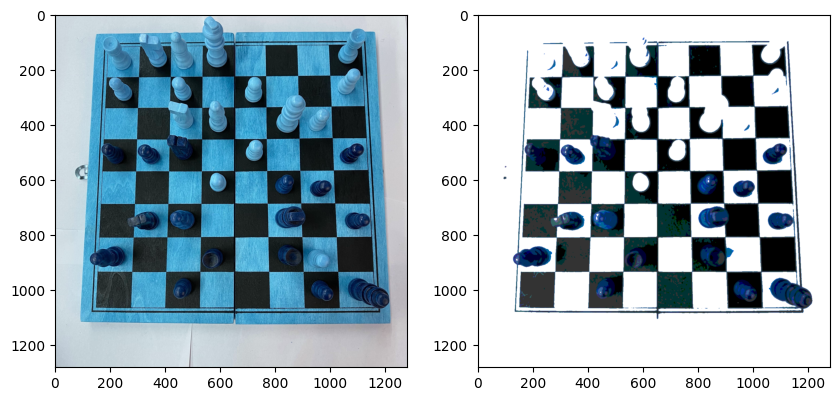

In [6]:
image = img_set[2]

image_1 = background_op(image, 1.5, -50)

fig, axs = plt.subplots(1,2,figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(image_1)

### Canny detector

## Coordinate system generation

### Hough lines transform

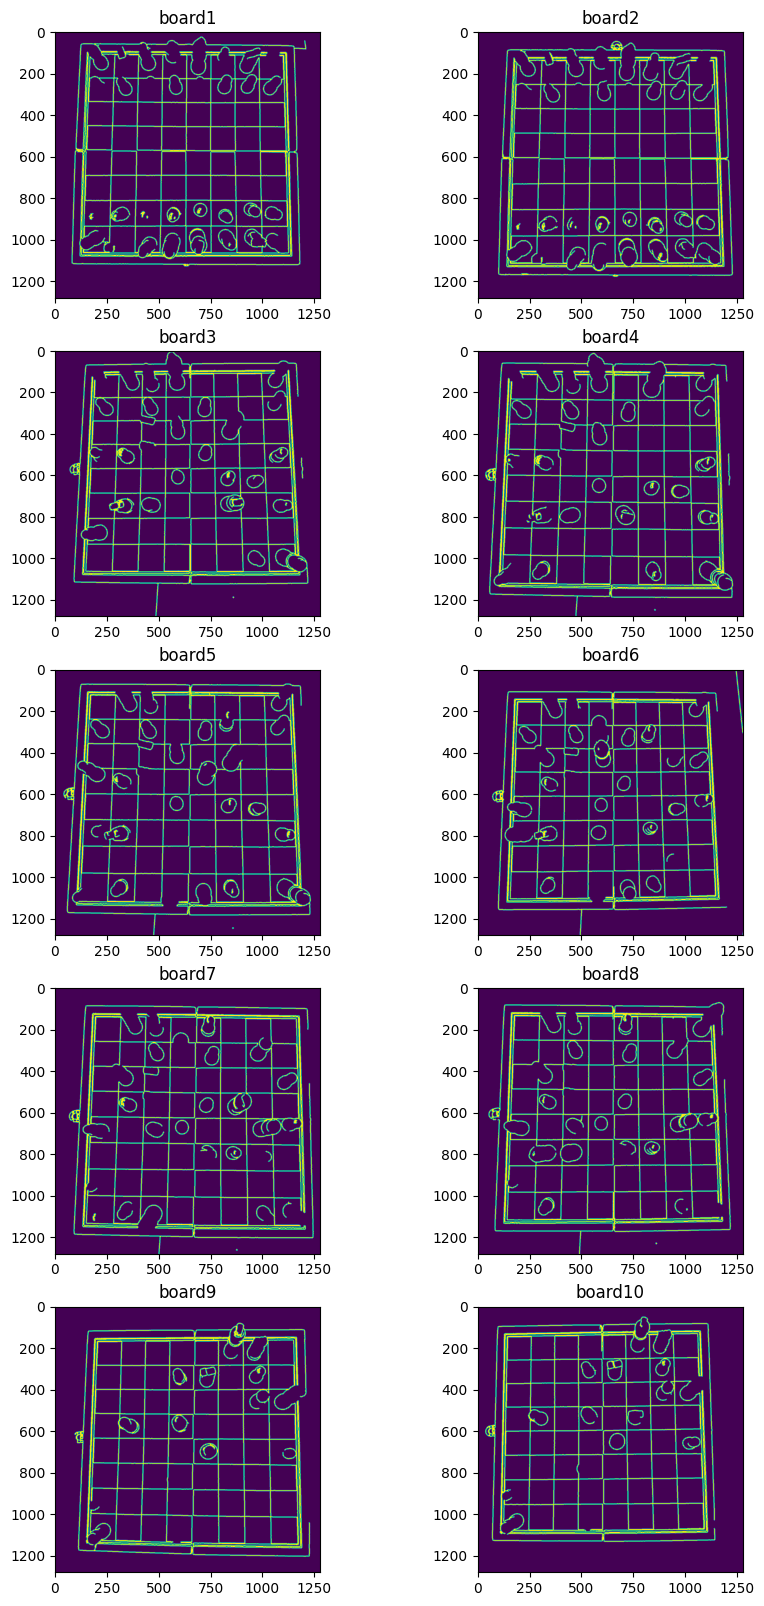

In [7]:
trans_edges = []

for img in img_set: 
    #img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    v = np.median(img)
    sigma = 0.5
    lower = int((1.0 - sigma) * v)
    upper = int((1.0 + sigma) * v + 10)
    #print(f"lower {lower}, upper {upper}")
    #thres = cv.threshold(img,v-10,255,cv.THRESH_BINARY)
    blur = cv.blur(img,(3,3),0) 
    edge = cv.Canny(blur, 80, 300) #70,250 for old
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
    dilated = cv.dilate(edge, kernel, iterations=2)
    trans_edges.append(dilated)
display_multiple_img(trans_edges)

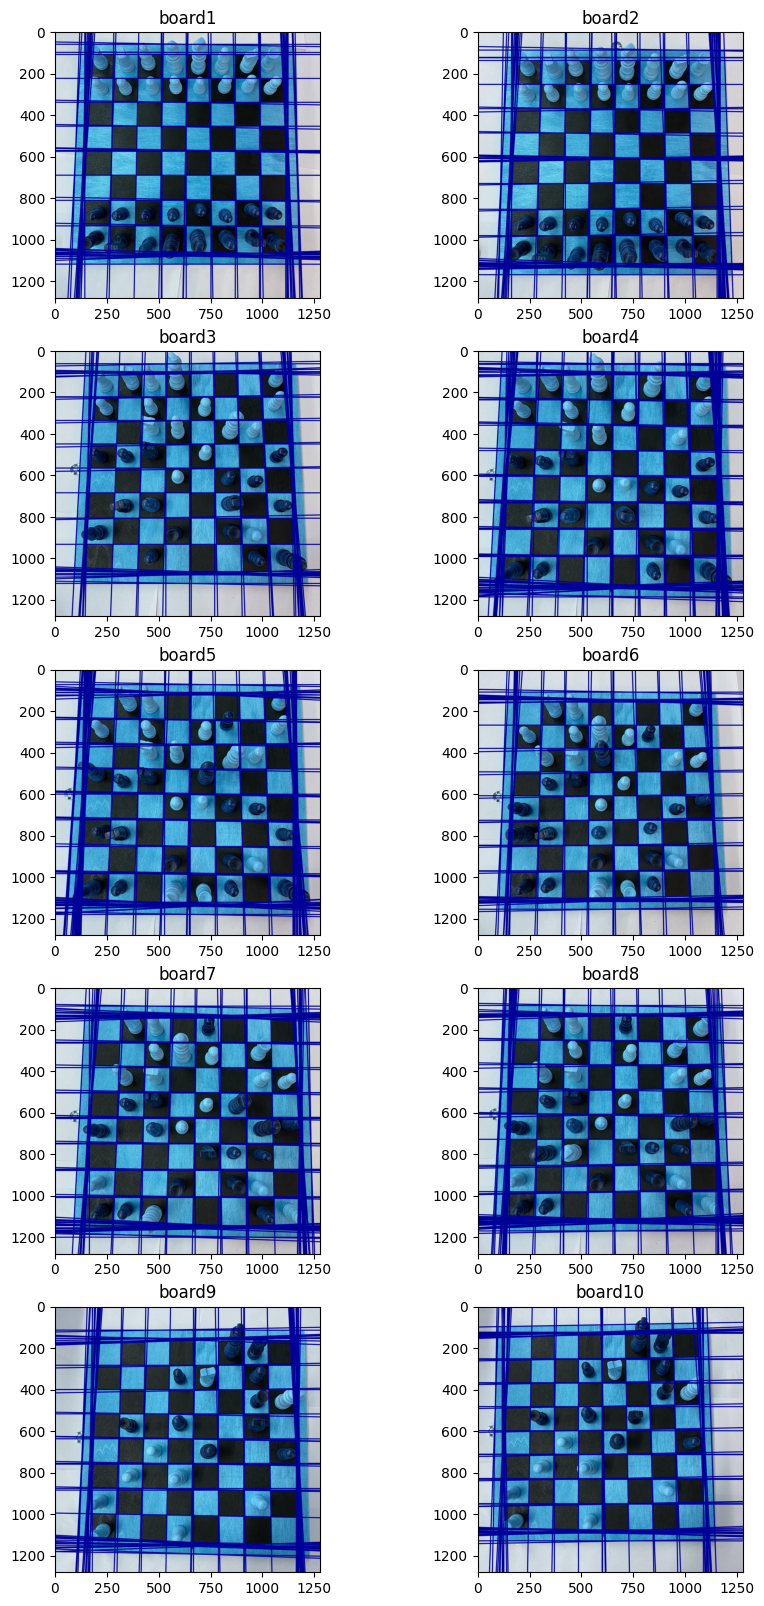

In [8]:
hough_lines = []
img_lined = []

for edge, img in zip(trans_edges, img_set):
    v = int(np.median(img))
    lines = cv.HoughLines(edge, 1, np.pi/180, v*3)
    hough_lines.append(lines)
    img_line = img.copy()
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
            cv.line(img_line, pt1, pt2, (0,0,152), 3, cv.LINE_AA)
    img_lined.append(img_line)
display_multiple_img(img_lined)

### Filtering the lines

In [9]:
horizontal_lines = []
vertical_lines = []
total_lines = []
df_test = []

for lines in hough_lines:
    
    if lines is not None:

        df = pd.DataFrame(lines[:,0,:]).rename(columns={0: "Rho", 1: "Theta"})
        df["diff"] = df["Rho"].diff() + 10*np.abs(df["Theta"].diff())
        new_lines = df
        new_lines["a"] = new_lines["Theta"].apply(math.cos)
        new_lines["b"] = new_lines["Theta"].apply(math.sin)
        new_lines["slope"] = -new_lines["a"]/new_lines["b"]
        new_lines["intercept"] = new_lines["Rho"]/new_lines["b"]

        mask_vert = (np.abs(new_lines["a"]) > 0.97) & (np.abs(new_lines["b"]) < 0.4 )
        mask_vert_2 = new_lines.isin([np.inf]).any(axis=1)
        mask_horizontal = (np.abs(new_lines["a"]) < 0.97) & (np.abs(new_lines["b"]) > 0.9 )
        vertical_2 = new_lines[mask_vert_2 + mask_vert]
        horizontal = new_lines[mask_horizontal]

        horizontal = horizontal.sort_values(by="intercept")
        horizontal["diff"] = horizontal["intercept"].diff()
        horizontal_f = horizontal[(horizontal["diff"]>55) | horizontal["diff"].isna()]

        vertical_2["x_intercept"] = vertical_2["Rho"].abs()
        vertical_2 = vertical_2.sort_values(by="x_intercept")
        vertical_2["diff"] = np.abs(vertical_2["x_intercept"]).diff()
        vertical_2_f = vertical_2[(vertical_2["diff"] > 40) | (vertical_2["diff"].isna())]

        horizontal_lines.append(horizontal_f)
        vertical_lines.append(vertical_2_f)
        total_lines.append(len(new_lines))
        df_test.append(df)
    
    else: 
        horizontal_lines.append(None)
        vertical_lines.append(None)
        total_lines.append(None)

/tmp/ipykernel_10983/3793639974.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vertical_2["x_intercept"] = vertical_2["Rho"].abs()
/tmp/ipykernel_10983/3793639974.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vertical_2["x_intercept"] = vertical_2["Rho"].abs()
/tmp/ipykernel_10983/3793639974.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

### Displaying the lines

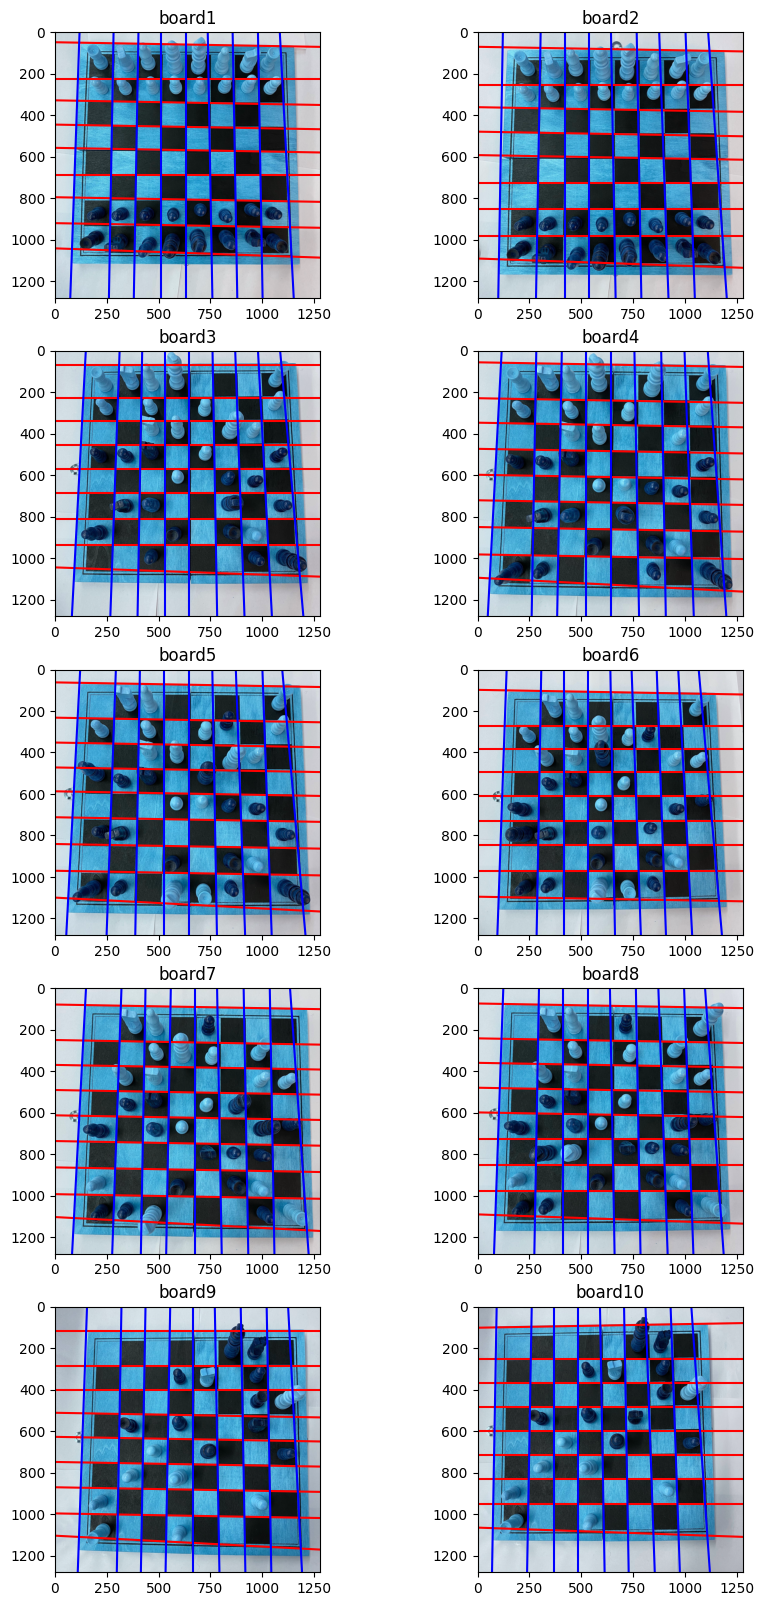

In [10]:
r = 1

fig, axs = plt.subplots(5,2,figsize=(10,20))

for horizontal, vertical, total, img in zip(horizontal_lines, vertical_lines, total_lines, img_set):
    
    if total is not None:
   
        plt.subplot(5,2,r)
        plt.title(f"board{r}")
        x = np.linspace(0, img.shape[1],total)
        x_h = horizontal["slope"].tolist()
        y_h = horizontal["intercept"].tolist()
        for i in range(len(x_h)):
            y = x_h[i] * x + y_h[i]
            plt.plot(x, y, '-r', label = f"line{i}")
            ax = plt.gca()
            ax.set_xlim([0, img.shape[1]])
            ax.set_ylim([img.shape[0], 0])

        vert = vertical["Rho"].tolist()
        x_v = vertical["slope"].tolist()
        y_v = vertical["intercept"].tolist()
        for i in range(len(x_v)):
            if x_v[i] == np.inf or x_v[i] == -np.inf:
                plt.axvline(x = vert[i], color = 'b')
            else: 
                y = x_v[i] * x + y_v[i]
                plt.plot(x, y, '-b', label = f"line{i}")
        plt.imshow(img)
        
    else: pass
    
    r += 1

### Intersections

In [11]:
def intersection(line1, line2):
    if np.inf not in [line1[0], line1[1], line2[0], line2[1]] or -np.inf not in [line1[0], line1[1], line2[0], line2[1]]:
        x0 = (line2[1] - line1[1]) / (line1[0] - line2[0])
        y0 = line1[0] * x0 + line1[1]
    else:
        if np.inf in line1 or -np.inf in line1:
            linev = line1
            linenv = line2
        else:
            linev = line2
            linenv = line1
        x0 = linev[2]
        y0 = linenv[0] * x0 + linenv[1]
        
    return x0, y0

In [12]:
intersections = []
intersection_df = []

for horizontal, vertical in zip(horizontal_lines, vertical_lines):
    
    if vertical is not None:
    
        intersections_p = []
        total_lines = pd.concat([horizontal, vertical])

        x_l = total_lines["slope"]
        y_l = total_lines["intercept"]
        r_l = total_lines["Rho"]

        for x1,y1,r1 in zip(x_l, y_l, r_l):
            for x2,y2,r2 in zip(x_l, y_l, r_l):
                line1 = (x1, y1, r1)
                line2 = (x2, y2, r2)
                if line1 != line2:
                    if line1[0] - line2[0] != 0:
                        x0, y0 = intersection(line1, line2)
                        intersections_p.append((round(x0,0), round(y0,0)))

        intersections_pd = pd.DataFrame(intersections_p)
        intersections_pd = intersections_pd[intersections_pd>0][intersections_pd<1400].dropna().drop_duplicates().reset_index()
        x_in = intersections_pd[0].to_list()
        y_in = intersections_pd[1].to_list()

        intersection_df.append(intersections_pd)
        intersections.append((x_in, y_in))
        
    else:
        intersection_df.append(None)
        intersections.append(None)

### Displaying the intersections

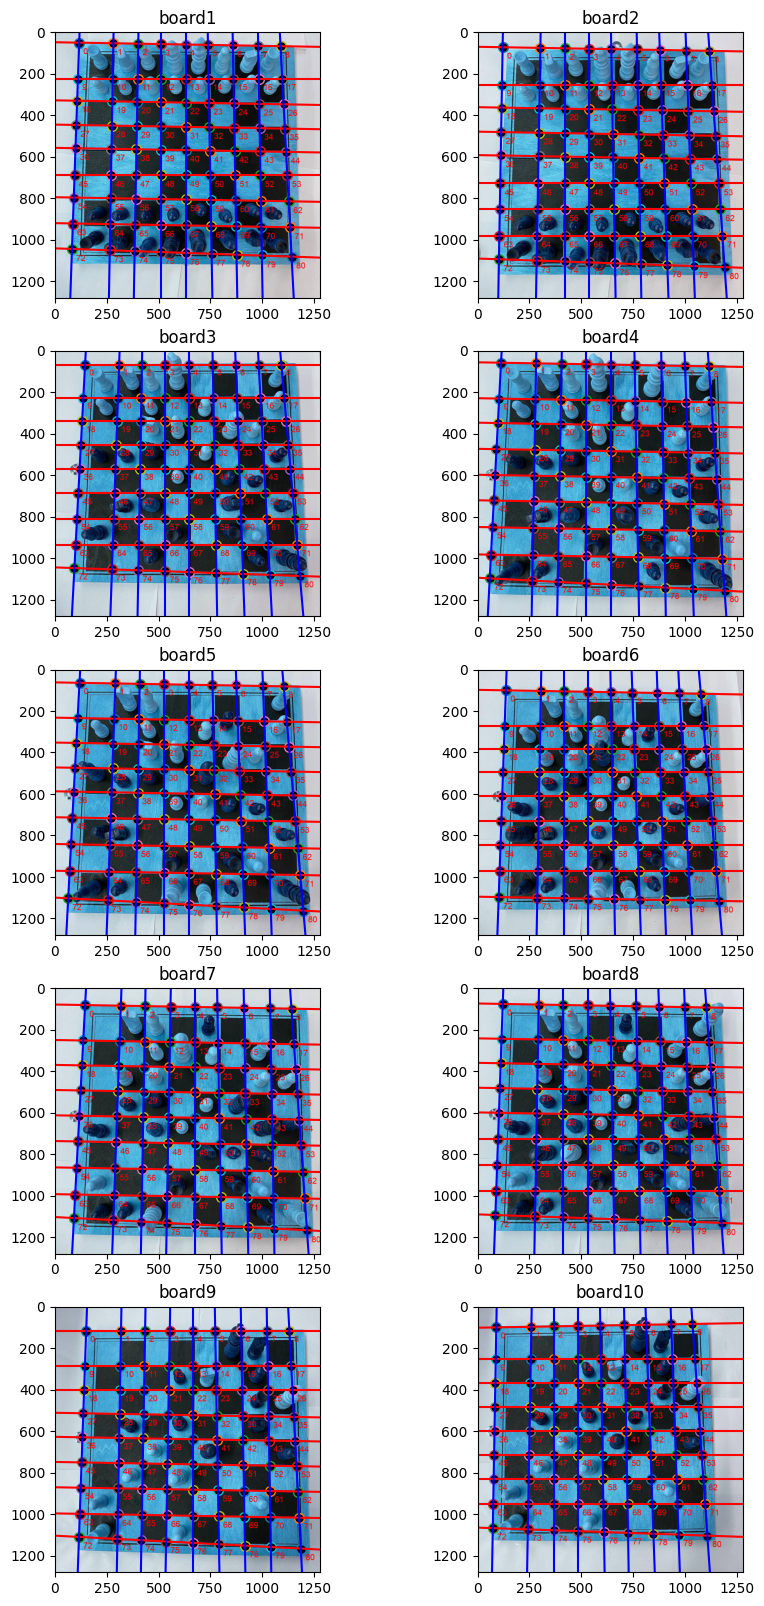

In [13]:

i = 0
r = 1
img_inter = []
fig, axs = plt.subplots(5,2,figsize=(10,20))

for inter, img, horizontal, vertical in zip(intersections,img_set, horizontal_lines, vertical_lines):
    
    if inter is not None:
    
        plt.subplot(5,2,r)
        plt.title(f"board{r}")
        img_2 = Image.fromarray(img)
        for i in range(len(inter[0])):
            text = f"{i}"
            x1 = inter[0][i]
            y1 = inter[1][i]
            plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="black")
            ax = plt.gca()
            ax.set_xlim([0, img.shape[1]])
            ax.set_ylim([img.shape[1], 0])
            draw = ImageDraw.Draw(img_2)
            font_type = ImageFont.truetype("arial.ttf", 40)
            draw.text((x1+20,y1+20),text, font=font_type, fill=255)
        img_inter.append(img_2)

        x_h = horizontal["slope"].tolist()
        y_h = horizontal["intercept"].tolist()
        vert = vertical["Rho"].tolist()
        x_v = vertical["slope"].tolist()
        y_v = vertical["intercept"].tolist()

        for i in range(len(x_h)):
            y = x_h[i] * x + y_h[i]
            plt.plot(x, y, '-r', label = f"line{i}")
            ax = plt.gca()
            ax.set_xlim([0, img.shape[1]])
            ax.set_ylim([img.shape[0], 0])

        for i in range(len(x_v)):
            if x_v[i] == np.inf or x_v[i] == -np.inf:
                plt.axvline(x = vert[i], color = 'b')
            else: 
                y = x_v[i] * x + y_v[i]
                plt.plot(x, y, '-b', label = f"line{i}")
        plt.imshow(img_2, cmap="gray")
    
    else:
        pass
    
    r += 1

### Coordinate system

In [52]:
coordinates = []
white_bottom = False
for inter in intersection_df:
    if inter is not None:
        if len(inter) > 80:
            inter = inter.drop(columns="index")
            A1 = inter.loc[0].to_list()
            coordinate = {}
            letters = ["A", "B", "C", "D", "E", "F", "G", "H"]

            if white_bottom == True:
                i = 0
                for col in letters:
                    for line in range(8):
                        val = inter.loc[73+i - 9*line].to_list()
                        text = f"{col}{line + 1}"
                        coordinate[text] = val
                    i += 1
            else:
                i = 0
                for col in letters:
                    for line in range(8):
                        val = inter.loc[17-i + 9*line].to_list()
                        text = f"{col}{line + 1}"
                        coordinate[text] = val
                    i += 1
        coordinates.append(coordinate)
    else: coordinates.append(None)

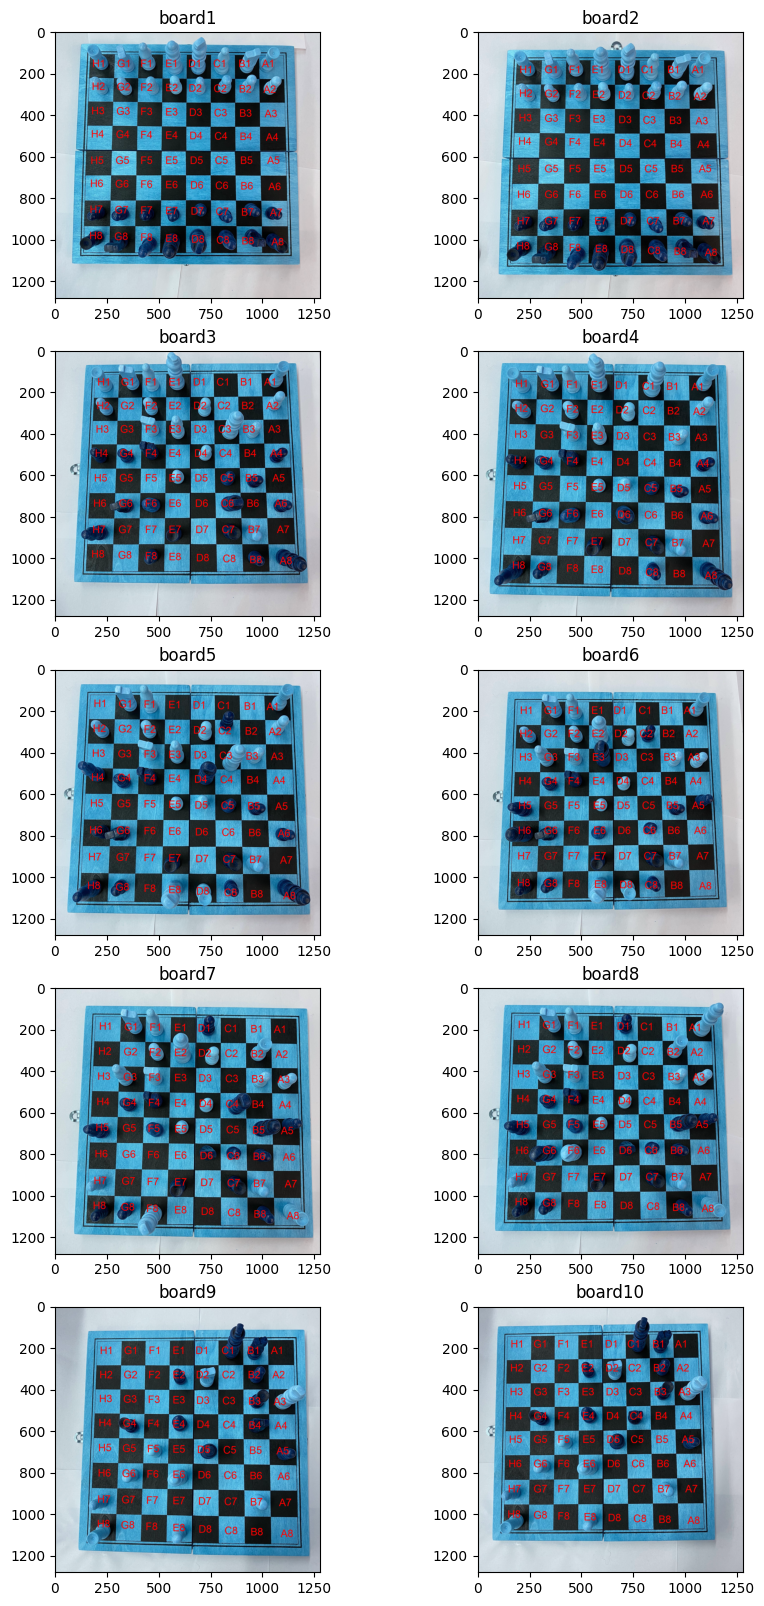

In [53]:
img_coor = []  
for img, coordinate in zip(img_set, coordinates):
    if coordinate is not None:
        img_3 = Image.fromarray(img)
        for key, value in coordinate.items():
            text = key
            pos = (value[0]-100, value[1]-100)
            draw = ImageDraw.Draw(img_3)
            font_type = ImageFont.truetype("arial.ttf", 50)
            draw.text(pos,text, font=font_type, fill=255)
        img_coor.append(img_3)
    else: img_coor.append(np.zeros((1280, 1280), dtype = np.uint8))
display_multiple_img(img_coor)

## Square selection

95.78236397748593


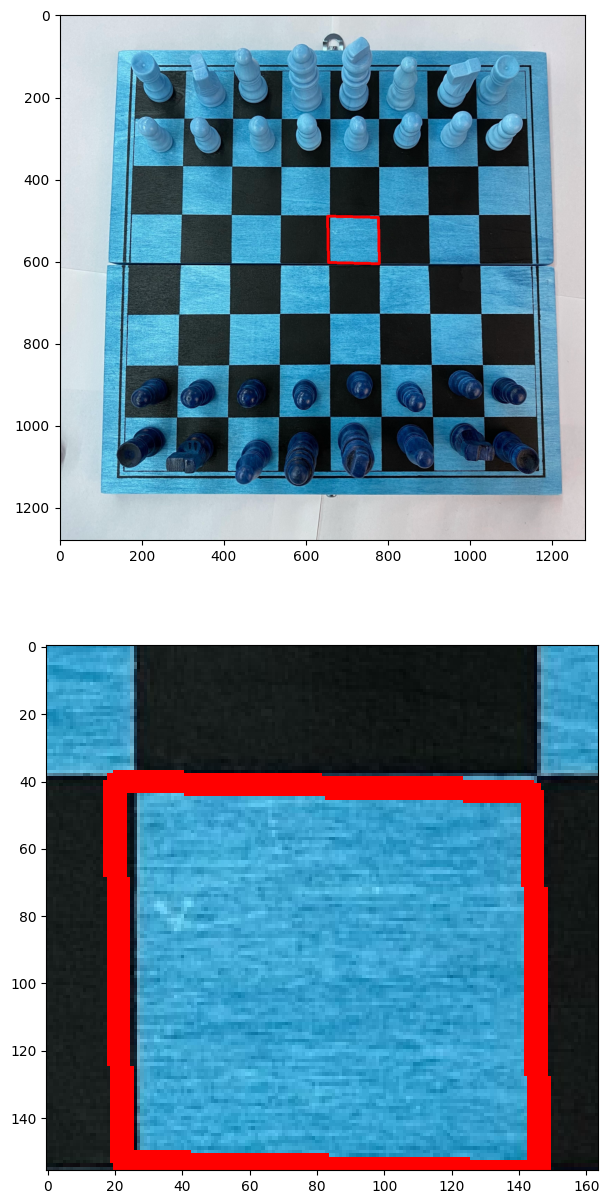

In [19]:
square = intersections[1]
img = img_set[1].copy()
#img_plus = background_op(img, 1.5, -50)
col = 4
lin = 3
padding = 40

blur = cv.blur(img,(2,2),0) 
edge = cv.Canny(blur, 70, 250) #70,250 for old
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
dilated = cv.dilate(edge, kernel, iterations=3)
#cv.cvtColor(img, cv.COLOR_RGB2GRAY)
#img_plus = cv.addWeighted(img, 1, dilated, 1, 0)
img_plus = img

corner_1 = [int(square[0][col + 9 * lin]), int(square[1][col + 9 * lin])]
corner_2 = [int(square[0][col + 1 + 9 * lin]), int(square[1][col + 1 + 9 * lin])]
corner_3 = [int(square[0][col + 9*(lin+1) + 1]), int(square[1][col + 9*(lin+1) + 1])]
corner_4 = [int(square[0][col + 9*(lin+1)]), int(square[1][col + 9*(lin+1)])]
corner_sq = [corner_1, corner_2, corner_3, corner_4]

crop_img = img_plus[max(corner_1[1]-padding,0):corner_3[1], max(corner_1[0]-int(padding/2),0):corner_2[0]+int(padding/2)]

i = 4
while i > 0:
    c = i % 4
    cv.line(img_plus,corner_sq[c] ,corner_sq[c-1] , color = 255, thickness=5)
    i -=1

black_median = 40
white_median = 20
print(np.mean(crop_img))

plt.figure(figsize=(15,15));
plt.subplot(2,1,1);    
plt.imshow(img_plus);
plt.subplot(2,1,2); 
plt.imshow(crop_img);

In [17]:
#img = trans_img[1].copy()
#img = np.clip(1.3*img + 40, 0, 255).astype("uint8")
#img_plus = background_op(img, 1.5, -50)
font = cv.FONT_HERSHEY_SIMPLEX
padding = 40
all_img_crop = []

for square, img in zip(intersections, img_set):
    if square is not None:
        corner_sq = []
        crop_imgs = []

        blur = cv.blur(img,(3,3),0) 
        edge = cv.Canny(blur, 50, 300) #70,250 for old
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
        dilated = cv.dilate(edge, kernel, iterations=3)
        #img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        #img_plus = cv.addWeighted(img, 0, dilated, 1, 0)
        img_plus = img

        for lin in range(8):
            for col in range(8):

                corner_1 = [int(square[0][col+ 9 * lin]), int(square[1][col+ 9 * lin])]
                corner_2 = [int(square[0][col + 1+ 9 * lin]), int(square[1][col + 1+ 9 * lin])]
                corner_3 = [int(square[0][col + 9*(lin+1) + 1]), int(square[1][col + 9*(lin+1) + 1])]
                corner_4 = [int(square[0][col + 9*(lin+1)]), int(square[1][col + 9*(lin+1)])]
                corner_sq = [corner_1, corner_2, corner_3, corner_4]

                #crop_img = img_plus[corner_1[1]:corner_3[1], corner_1[0]:corner_2[0]]
                crop_img = img_plus[max(corner_1[1]-padding,0):corner_3[1]+int(padding/2), max(corner_1[0]-int(padding/2),0):corner_2[0]+int(padding)]
                crop_imgs.append(crop_img)
                #print(black_median - wiggle, white_median - wiggle, np.mean(crop_img), white_median + wiggle, black_median + wiggle)

                #if (np.mean(crop_img) < black_median + wiggle and np.mean(crop_img) > black_median - wiggle) or (np.mean(crop_img) < white_median + wiggle and np.mean(crop_img) > white_median - wiggle):
                    #text = "empty"   
                #else: text = "thing!"

                #i = 4
                #while i > 0:
                    #c = i % 4
                    #cv.line(img_plus,corner_sq[c] ,corner_sq[c-1] , color = 255, thickness=5)
                    #cv.putText(img, text, (corner_4[0] + 50, corner_4[1] - 50), font, 1, (255, 255, 255), 2, cv.LINE_AA)
                    #i -=1
                #cv.putText(img, str(int(np.max(crop_img))), (corner_4[0] + 50, corner_4[1] - 20), font, 1, (255, 255, 255), 2, cv.LINE_AA)
        all_img_crop.append(crop_imgs)
    else:
        all_img_crop.append(None)

In [157]:
save_path = "/home/thierry/code/zuzannaszu/chess_hackers/Crop_images/Final/whatareyoudoing/"
for ids, board in enumerate (all_img_crop):
    prefix = f"puzzle{start + ids}"
    if board is not None:
        for idx, img in enumerate (board):
            name = f"{prefix}-crop{idx}.jpeg"
            cv.imwrite(save_path + name, img)